In [3]:
import gym
from gym import spaces

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [42]:
STATES = [['MS' , '  ' , '  ' , '  ' , '  ' ],
          ['  ' , '  ' , '  ' , '  ' , 'FB' ],
          ['FF' , 'FF' , '  ' , 'CR' , '  ' ],
          ['  ' , '  ' , 'FB' , '  ' , '  ' ],
          ['FT' , '  ' , '  ' , '  ' , 'SR' ]]

ACTIONS = {
        'L': (0,-1), #Left
        'U': (-1,0), #Up
        'R': (0,1),  #Right
        'D': (1,0)   #Down
    }
REWARDS = {
        'FB' : -2, #Fire Ball
        'FF' : -3, #Fire Flower
        'CR' : 2,  #Coin Reward
        'SR' : 4,  #Star Reward
        'FT' : 10  #Flower Terminal State
    }

# Icons to be used for Visualization
ICONS = {
        '-2' : "./images/fire_ball.png",
        '-3' : "./images/fire_flower.png",
        '2'  : "./images/coin_reward.png",
        '4'  : "./images/star_reward.png",
        '10' : "./images/flower_goal_terminal.png",
        "MS" : "./images/mario_agent.png",
    }

In [73]:

class MyMarioEnvironment(gym.Env):
    def __init__(self, environment:list[list]=STATES, actions:dict=ACTIONS, rewards:dict=REWARDS, p_transition:float=1.0, epsilon:float=None, discount_factor:float=1, environment_type:str='Deterministic'):
        """This function is used to initialize the Environment Class

        Args:
            environment (list[list], optional): Represents the environment defined with characters. Defaults to STATES.
            actions (dict, optional): Map of actions allowed in the environment. Defaults to ACTIONS.
            rewards (dict, optional): Map of rewards allowed in the environment. Defaults to REWARDS.
            p_transition (float, optional): Probability of transition used for Stochastic Environment. Defaults to None.
            epsilon (float, optional): Used to exploration and exploitation policy (Not used for Part1). Defaults to None.
            discount_factor (float, optional): Used to discount the rewards (Not used for Part1). Defaults to None.
            environment_type (str, optional): The type of environment. Takes input 'deterministic' or 'stochastic'. Defaults to None.
        """

        self.environment = environment
        self.env_row, self.env_col = len(self.environment), len(self.environment[0])
        self.states, self.start_pt, self.end_pt, self.current_pt = self._get_state_space(environment, rewards)
        self.observation_space = spaces.Discrete(self.env_row*self.env_col)
        self.action_space = spaces.Discrete(len(actions))
        self.environment_type = environment_type
        self.p_transition = p_transition
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.cumulative_reward = 0
        self.observation = self.states.flatten()
        self.rewards = rewards
        self.rewards_space = self._get_reward_space(environment, rewards)
        self.max_timestep = 100
        self.timestep = 0
        self.actions, self.actions_map = self._map_actions_with_index(actions)
        self.legal_actions = actions

    def step(self, action:str):
        """Step function that perform next action

        Args:
            action (str): _description_

        Returns:
            observation, reward, done, info: _description_
        """
        if action not in self.legal_actions:
            self.new_reward = 0
        else:
            self.new_action, self.direction = self._get_action_by_p_tran(action)
            self.states[self.current_pt[0]][self.current_pt[1]] = self.rewards_space[self.current_pt[0]][self.current_pt[1]]
            self.current_pt = self._get_next_pt(self.actions_map[self.new_action])
            self.states[self.current_pt[0]][self.current_pt[1]] = -5
            self.new_reward = self._get_reward(self.current_pt)
            self.cumulative_reward += self.new_reward
            self.observation = self.states.flatten()
        
        self.timestep += 1
        done = True if self.timestep == self.max_timestep else False
        info = {'current_pt':self.current_pt}
        return self.observation, self.new_reward, done, info
        
    def reset(self):
        self.timestep = 0
        self.states, self.start_pt, self.end_pt, self.current_pt = self._get_state_space(self.environment, self.rewards)
        self.cumulative_reward = 0
        self.observation = self.states.flatten()
        return self.observation

    def render(self, mode:str="rgb", icons:dict=ICONS):
        if mode == "rgb":
            plt.imshow(self.states)
            plt.show()
        elif mode == "human":
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_xlim(0, 5)
            ax.set_ylim(0, 5)
            im = plt.imread("./images/bg.jpg")
            im = ax.imshow(im)
            # Rendering the images for all states.
            for r in range(self.env_row):
                for c in range(self.env_col):
                    if np.array_equal(self.current_pt,[r,c]):
                        img = icons['MS']
                    elif not np.array_equal(self.rewards_space[r][c],0):
                        img = icons[str(int(self.rewards_space[r][c]))]
                    else:
                        continue
                    agent = AnnotationBbox(OffsetImage(plt.imread(img), zoom=0.5), np.add((c,4-r), [0.5, 0.5]), frameon=False)
                    ax.add_artist(agent)      

            plt.xticks([0, 1, 2, 3, 4])
            plt.yticks([0, 1, 2, 3, 4])
            plt.grid()  # Setting the plot to be of the type 'grid'.  
            plt.show()

    def _get_next_pt(self, next_action):
        self.new_pt = self.current_pt + next_action
        if self.new_pt[0] < 0 or self.new_pt[0] == self.env_row or self.new_pt[1] < 0 or self.new_pt[1] == self.env_col:
            return self.current_pt
        else:
            return self.new_pt

    def _map_actions_with_index(self, actions):
        actions_list = [""]*self.action_space.n
        action_index_map_coordinate = {}
        index = 0
        for key in actions:
            actions_list[index] = key
            action_index_map_coordinate[index] = actions[key]
            index += 1
        return actions_list, action_index_map_coordinate

    def _get_state_space(self, environment:list[list]=None, rewards:dict=None):
        state_space = np.zeros((self.env_row,self.env_col))
        for r in range(self.env_row):
            for c in range(self.env_col):
                if environment[r][c] in rewards:
                    state_space[r][c] = rewards[environment[r][c]]
                
                if environment[r][c] == 'MS':
                    state_space[r][c] = -5 #if states is used for rendering
                    start = np.array((r,c))
                elif environment[r][c] == 'FT':
                    end = np.array((r,c))
                
                
        return state_space, start, end, start
    
    def _get_reward_space(self, environment:list[list]=None, rewards:dict=None):
        rewards_space = np.zeros((self.env_row,self.env_col))
        for r in range(self.env_row):
            for c in range(self.env_col):
                if environment[r][c] in rewards:
                    rewards_space[r][c] = rewards[environment[r][c]]                
        return rewards_space

    def _get_action_by_p_tran(self, action):
        if self.environment_type == "stochastic":
            actions_p_tran = np.zeros(self.action_space.n)
            actions_p_tran[self.actions.index(action)] = self.p_transition
            for i in range(self.action_space.n):
                if actions_p_tran[i] == 0:
                    actions_p_tran[i] == (1-self.p_transition)/(self.action_space.n - 1)
            final_action_index = np.random.choice(a = self.action_space.n, p = actions_p_tran)
            return final_action_index, self.actions[final_action_index]
        else:
            return self.actions.index(action), action
    
    def _get_reward(self, state):
        self.new_reward = self.rewards_space[self.current_pt[0]][self.current_pt[1]]
        self.rewards_space[self.current_pt[0]][self.current_pt[1]] = 0
        return self.new_reward

        

                    


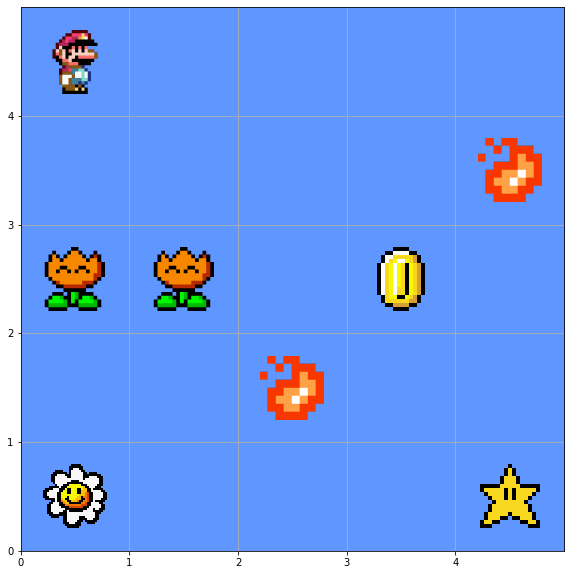

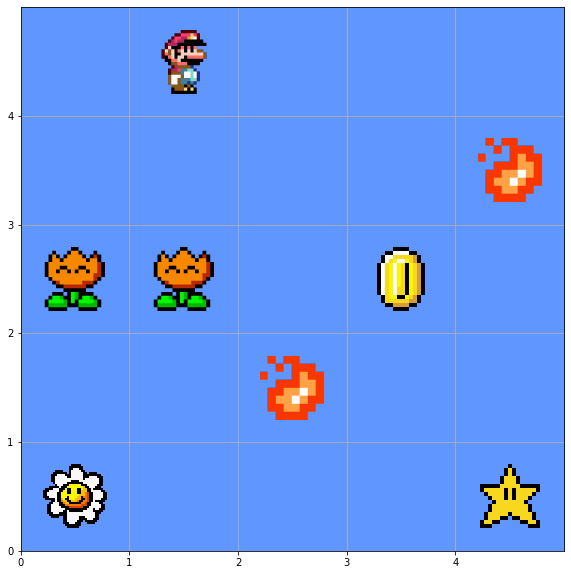

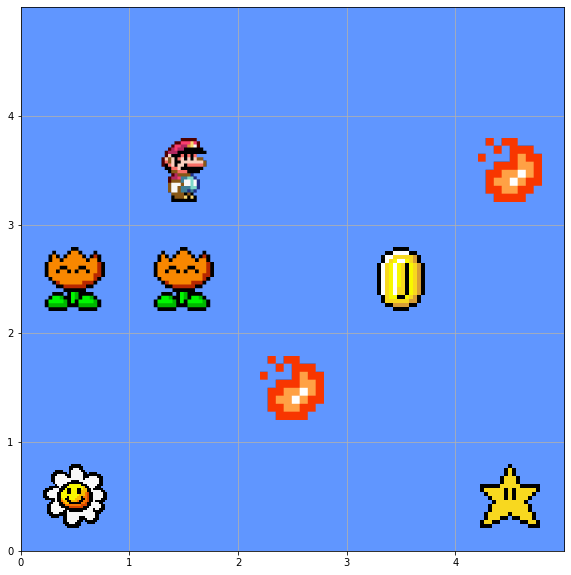

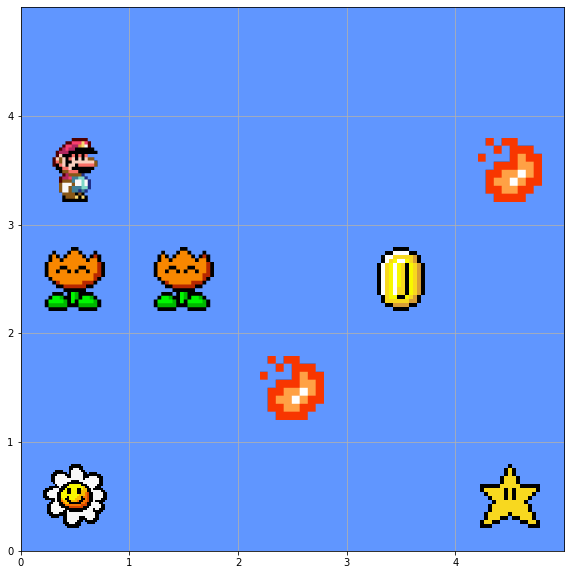

In [74]:
env = MyGridEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=1.0,epsilon=1.0,discount_factor=1)
env.render(mode="human",icons=ICONS)
for action in ['R','D','L']:
    observation, reward, done, info = env.step(action)
    # print(observation,info,reward)
    if done:
        env.render(mode="human",icons=ICONS)
        break
    else:
        env.render(mode="human",icons=ICONS)
